In [11]:
# import the necessary packages
from skimage.exposure import rescale_intensity
import numpy as np
import cv2

In [12]:
def convolve(image, K):
    # grab the spatial dimensions of the image and kernel
    (iH, iW) = image.shape[:2]
    (kH, kW) = K.shape[:2]

    # allocate memory for the output image, taking care to "pad"
    # the orders of the input image so the spatial size (i.e.,
    # width and height) are not reduced
    pad = (kW - 1) // 2
    image = cv2.copyMakeBorder(image, pad, pad, pad, pad,
        cv2.BORDER_REPLICATE)
    output = np.zeros((iH, iW), dtype="float")

    # loop over the input image, "sliding" the kernel across
    # each (x, y)-coordinate from left-to-right and top-to-bottom
    for y in np.arange(pad, iH + pad):
        for x in np.arange(pad, iW + pad):
            # extract the ROI of the image by extracting the
            # *center* region of the current (x, y)-coordinates
            # dimensions
            roi = image[y - pad:y + pad + 1, x - pad:x + pad + 1]

            # perform the actual convolution by taking the
            # element-wise multiplication between the ROI and
            # the kernel, the summing the matrix
            k = (roi * K).sum()

            # store the convolved value in the output (x, y)-
            # coordinate of the output image
            output[y - pad, x - pad] = k

    # rescale the output image to be in the range [0, 255]
    output = rescale_intensity(output, in_range=(0, 255))
    output = (output * 255).astype("uint8")

    # return the output image
    return output

Notice our method receives an image and a kernel (transformation matrix) and as it slides the kernel over the image matrix, applys the convolution (element multiplication and sum of all elements). The values of the convolution calculation are then placed in the output image, which is then converted to the 0-255 range.

In [18]:
# define our kernels
smallBlur = np.ones((7, 7), dtype="float") * (1.0 / (7 * 7))
largeBlur = np.ones((21, 21), dtype="float") * (1.0 / (21 * 21))

These are blur kernels. Each entry is 1/S where S is the total number of entries in the matrix. This, this kernel will multiply each input pixel by a small fraction and take the sum of all elements (meaning it's the average).

In [14]:
# construct a sharpening filter
sharpen = np.array((
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]), dtype="int")

# construct the Laplacian kernel used to detect edge-like
# regions of an image
laplacian = np.array((
    [0, 1, 0],
    [1, -4, 1],
    [0, 1, 0]), dtype="int")

# construct the Sobel x-axis kernel
sobelX = np.array((
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]), dtype="int")

# construct the Sobel y-axis kernel
sobelY = np.array((
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]), dtype="int")

# construct an emboss kernel
emboss = np.array((
    [-2, -1, 0],
    [-1, 1, 1],
    [0, 1, 2]), dtype="int")

In [15]:
# construct the kernel bank, a list of kernels we're going to apply
kernelBank = (
    ("small_blur", smallBlur),
    ("large_blur", largeBlur),
    ("sharpen", sharpen),
    ("laplacian", laplacian),
    ("sobel_x", sobelX),
    ("sobel_y", sobelY),
    ("emboss", emboss))

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline

image_path = 'photo.jpg'
    
# load the input image and convert it to grayscale
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

[INFO] Applying small_blur
[INFO] Applying large_blur
[INFO] Applying sharpen
[INFO] Applying laplacian
[INFO] Applying sobel_x
[INFO] Applying sobel_y
[INFO] Applying emboss


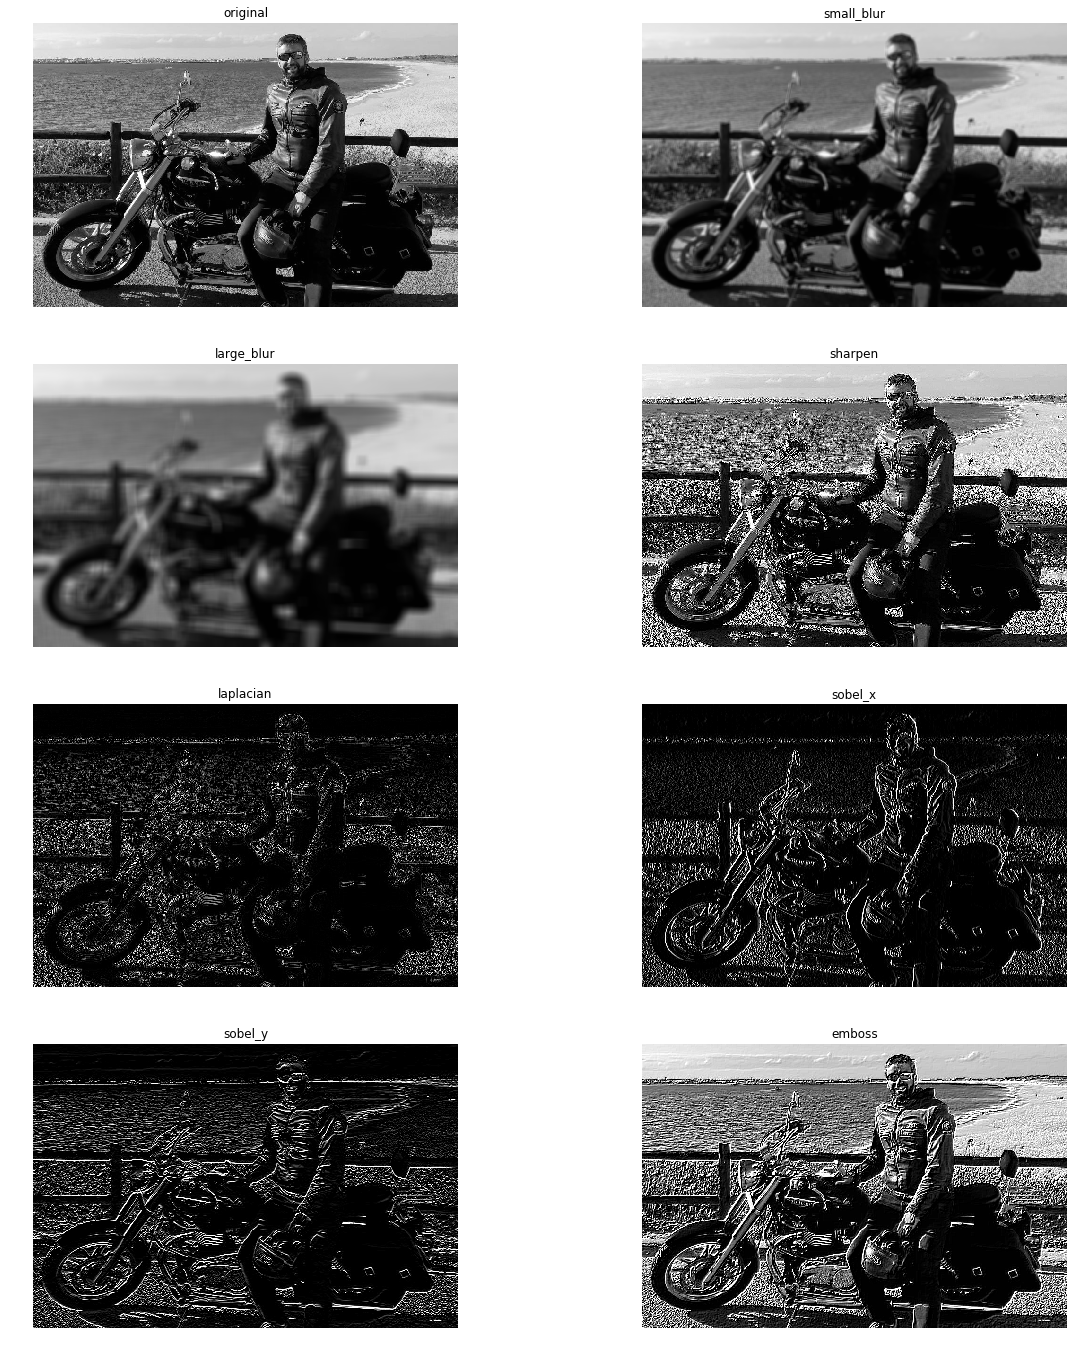

In [63]:
fig = plt.figure(figsize=(20,24))

def setupImage(title, image, index):
    # show the output images
    ax = plt.subplot(420 + index)
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))

setupImage('original', gray, 1)

i = 2
# loop over the kernels
for (kernelName, K) in kernelBank:
    # apply the kernel to the grayscale image
    print('[INFO] Applying {}'.format(kernelName))
    convolveOutput = convolve(gray, K)
    # show the output images
    setupImage(kernelName, convolveOutput, i)
    i += 1
 
plt.show()

So, here we are handcrafting kernels for specific image processing operations. We also see how applying these kernels (which is basically sliding the kernel on top of the image and applying some math operations) results in creating filters that provide smoothing, sharpening and edge detection.

All very cool, but is there a way that these filters themselves can be learned? Yes, and it's done through **Convolutional Neural Networks (CNNs)**